In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import peakutils
import logging
import datetime
import warnings
from lmfit.models import PseudoVoigtModel, GaussianModel
from jupyterthemes import jtplot

In [3]:
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *
from xps.xps_fits import *

jtplot.style('default', grid=False)
logging.getLogger().setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")

plt.rcParams['errorbar.capsize'] = 8
plt.rcParams['font.size'] = 18
plt.rc('font', size= 18)
plt.rc('legend', fontsize= 15)
plt.rc('xtick', labelsize= 18)
plt.rc('ytick', labelsize= 18)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)
plt.rcParams["xtick.major.size"] = 8

plt.rcParams['lines.linewidth'] = 4
asf = dict({'C_1s' : 0.296, 'O_1s' : 0.711, 'N_1s' : 0.477, 'Ba_3d' : 7.49,
            'Br_3p' : 1.054, 'Cu_2p' : 5.321, 'Ba_4d': 2.35,
           'In3d' : 4.359, 'Sn3d' : 4.725, 'Cl_2p' : 0.891, 'Si2p': 0.339})


In [20]:
def plot_region(xp : XPS_experiment, region : str, col: str = None, lb : str = None, ax = None, offset: float = 0.):
    """Quick region plotter"""
    if lb == None: lb = xp.name
    if ax == None: ax = plt.gca()
#     offset *= np.average(xp.dfx[region].dropna().counts.values)
    p1 = ax.plot(xp.dfx[region].energy, xp.dfx[region].counts + offset, label=lb)
    
    if col != None:
        p1[0].set(color=col)
    elif xp.color :
        p1[0].set(color=xp.color)

    if xp.ls:
        p1[0].set(linestyle=xp.ls)

    cosmetics_plot()
    return p1[0]

def plot_xp_regions(experiments : list, regions : list, colors : list = [], ncols: int = 3, flag_shift: bool = False):
    """Subplots all regions of a list of experiments (unnormalised)"""
    rows = int(np.ceil(len(regions) / ncols))

    fig, ax = plt.subplots(rows, ncols, figsize=(16, 8))
    fig.add_subplot(111, frameon=False, xticks=[], yticks=[])  # Used for common xlabel and ylabel

    for i,r in enumerate(regions):
        enmx, comx = [], [] # Peak point lists
        for c,xp in enumerate(experiments):
            j, k = i//ncols, i%ncols

            if i == len(regions) - 1:   # Set labels from last region
                lb = xp.name

            else:
                lb='__nolabel__'

            try:
                li = plot_region(xp, r, ax=ax[j][k], lb=lb)
                ax[j][k].legend()
                ax[j][k].invert_xaxis()
            except KeyError:    # Auto-exclude regions not recorded for a particular experiment
                pass
            if flag_shift:
                argmx = np.argmax(xp.dfx[r].counts)
                enmx.append(xp.dfx[r].energy.loc[argmx])
                comx.append(xp.dfx[r].counts.loc[argmx])

        ax[j][k].set_title(r)
        ax[j][k].set_yticks([])
        if flag_shift:  ax[j][k].plot(enmx, comx, '--k', lw=2.5)

        if len(experiments)%2 == 0:
            ax[j][k].invert_xaxis()
    plt.xlabel('\nEnergy [eV]', ha='center')
    plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
    return ax

def plot_fit_result(xp: XPS_experiment, region: str, fitRes: ModelResult = None,
                    lb : str = None, ax = None, col:str = None, offset: float = 0.3,
                    plot_comps: bool = True, flag_fill: bool = False):
    if ax == None : ax = plt.gca()
    if col == None: col = xp.color
    if lb == None: lb = xp.name
    if fitRes == None: fitRes = xp.fit[region]
        
    offset *= np.average(xp.dfx[region].dropna().counts.values)
    p1 = ax.scatter(xp.dfx[region].energy, xp.dfx[region].counts + offset,
                    color=col, label=lb, zorder = 1)

    x = xp.dfx[region].dropna().energy

    ax.plot(x, fitRes.best_fit + offset, '-', color=col)#, label='best fit, $\chi^2_N$ = %i' %fitRes.redchi)
#     ax.legend(loc='upper left')

    if plot_comps:
        comps = fitRes.eval_components(x=x)
        for compo in comps:
            posx = fitRes.best_values[compo+'center']
            colc = ax.plot(x, comps[compo], ls='dotted', lw=2, color=col, label='__nolabel__')[0].get_color()

            ax.vlines(x=posx, ymin=0, ymax=comps[compo].max(), linestyle='-', colors=col)
            ax.text(x=posx, y=comps[compo].max()*0.9, s='%.1f' %posx, fontsize=12)
            if flag_fill:
                ax.fill_between(x, y1 = 0, y2 = comps[compo], alpha=0.3, color=col)

    return ax, offset

def table_fit_area(exps: list, region: str):
    """Print a table with fit results and relative areas dict"""
    par_table = ['center', 'fwhm', 'amplitude', 'area']
    head = 'comp\t'

    for par in par_table: 
        head += '%s\t'%par

    print(head)

    for xp in exps:
        fit = xp.fit[region]
        for i, comp in enumerate(fit.components):
            pref = comp.prefix
            line = pref[:-1] + '\t'

            for par in par_table[:-1]:
                line += '%.2f\t '%fit.values[pref + par]        
            line += '%.2f'%xp.area[region+'_'+pref]

            print(line)

In [5]:
def n_layers(xpf: XPS_experiment, xp0: XPS_experiment, r_ml: float, region: str, mfp: float, takeoff: float):
    """Estimate number of layers from the attenuation in substrate (region) between an experiment
    with the layer xpf and a reference (clean) experiment xp0.
    For uncorrected thickness estimation (in nm), use function layer_thickness.
    Parameters:
    ------------
    - xpf: Experiment with substrate CL attenuated by layer.
    - xp0: Clean experiment for reference.
    - r_ml: Size of a Monolayer, in the same units as mfp
        (if the attenuation corresponds to sub-ML regime, correct for bare substrate contribution)
    - region: substrate region.
    - mfp: mean free path of the molecule conforming the layer (use QUASES to compute it).
        NOTE: Use EAL to account for elastic scattering, if negligible use IMFP.
    - takeoff: angle in degrees between the surface normal and the analyser entry.

    Returns:
    layers, dlayers: number layer and associated error
    -----------
    """
    #from invisible_cities.core.system_of_units import nm

    try:
        If = xpf.area[region]
        I0 = xp0.area[region]

    except KeyError:
        If = np.trapz(xpf.dfx[region].dropna().counts, dx=0.1)
        I0 = np.trapz(xp0.dfx[region].dropna().counts, dx=0.1)

    dIf = np.sqrt(If)
    dI0 = np.sqrt(I0)

    costh = np.cos(takeoff*np.pi/180)

    thick = mfp*costh*np.log(I0/If)
    dthick = mfp*costh*np.sqrt((dI0/I0)**2 + (dIf/If)**2)

    if thick < r_ml:
        layers = (If/I0 - 1) / (np.exp(- r_ml * costh / mfp) - 1)
        dlayers = layers * np.sqrt( (dIf/If)**2 + (dI0/I0)**2 )
    else:
        layers = thick / r_ml
        dlayers = dthick / r_ml

    xpf.area.update({'layers' : layers})
    xpf.area.update({'dlayers' : dlayers})

    return layers, dlayers

def arrange_coverages(experiments: list, inds: list,
                      r_ml: float, region: str, mfp: float, takeoff: float)->np.matrix:
    """Estimate n_layers for a list of experiments following the indices inds
    Parameters:
     - experiments: list of XPS_experiment to look into
     - inds: list of indices. It must be arranged such that each set of measurements
             has its reference (clean substrate) index at the end of each list.
             Example:  inds = [[0,1,2,3,5,7,8, 4], [9, 10]]
             will take experiments[4] as clean_substrate, and compute the thickness of experiments[0],
             experiments[1], experiments[2]... Then it will take experiments[10] as clean_substrate and
             compute the thickness for experiments[9]
     - all other params must be passed as for n_layers
    Returns:
    layers_res: matrix (M x 2), with column 0 is the mean value of n_layers and column 1 its error, and
    where M is the number of experiments passed for computation.
    """
    layers_res = []
    for lref in inds:
        for li in lref[:-1]:
            lay, dlay = n_layers(xpf=experiments[li], xp0=experiments[lref[-1]],
                                           r_ml = r_ml, region=region, mfp=mfp, takeoff=takeoff) 
            experiments[li].area['layers'] = lay
            experiments[li].area['dlayers'] = dlay
            
            layers_res.append((lay, dlay))
    layers_res = np.matrix(layers_res)
    return layers_res

def plot_coverages(experiments, label='__nolabel__'):
    layers, dlayers = [], []
    names = []
    for xp in experiments:
        try:
            layers.append(xp.area['layers'])
            dlayers.append(xp.area['dlayers'])
            names.append(xp.name.replace('_', ' ') )
        except KeyError:
            pass

    ax = plt.gca()
    ax.errorbar(x=layers, xerr=dlayers, y=names, fmt='o', markersize=10, label=label)
    ax.set_xlabel('Layers')
    ax.legend()

# Figures paper

## Shift in sample 13 (BaCl2)

In [14]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21*/*.xy'

files = glob.glob(path, recursive=True)
files.sort()
files

['/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/20210421_16-Cu_FBI_subl_22min.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/20210421_16-Cu_FBI_subl_22min_BaCl2_1min.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/20210421_16-Cu_FBI_subl_22min_BaCl2_2min.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/20210421_16-Cu_FBI_subl_22min_BaCl2_6min.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/20210421_16-Cu_FBI_subl_22min_BaCl2_6min_200grad.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/20210421_16-Cu_FBI_subl_22min_BaCl2_6min_250grad.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/20210421_16-Cu_FBI_subl_22min_BaCl2_6min_300grad.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/20210421_16-Cu_clean.xy']

In [18]:
progba = [xps_data_import(f) for f in files]
progba[0].color = 'g'
progba[3].color = 'b'

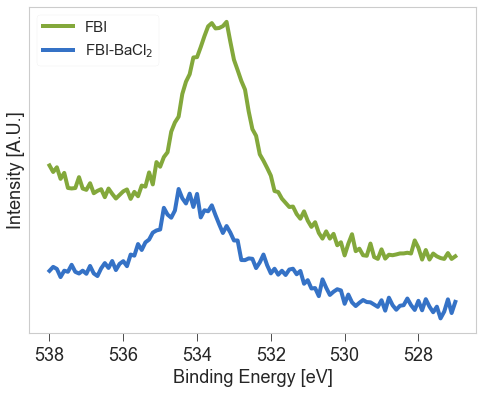

In [27]:
region = 'O_1s'
fig = plt.figure(figsize=(8, 6))
plot_region(progba[0], region)
plot_region(progba[3], region)
ax = plt.gca()
ax.set(xlabel = 'Binding Energy [eV]', ylabel='Intensity [A.U.]', yticks=[])
ax.invert_xaxis()
ax.legend(handles=ax.get_lines(), labels=['FBI', 'FBI-BaCl$_2$'], loc='upper left')

## Shift in sample 9 (NaCl) for inset

In [29]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_05_04*/*.xy'

files = glob.glob(path, recursive=True)
files.sort()
files

['/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_05_04_Cu/20210504_18-Cu_FBI_subl_20min.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_05_04_Cu/20210504_18-Cu_clean.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_05_04_Cu/20210505_18-Cu_FBI_subl_20min_NaCl_2min.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_05_04_Cu/20210506_18-Cu_FBI_subl_20min_NaCl_2min_200ºC.xy']

In [30]:
nacl = [xps_data_import(f) for f in files]
nacl[0].color = 'g'
nacl[2].color = 'y'

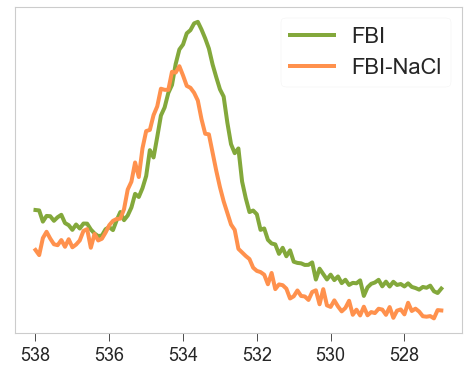

In [35]:
region = 'O_1s'
fig = plt.figure(figsize=(8, 6))
plot_region(nacl[0], region)
plot_region(nacl[2], region)
ax = plt.gca()
ax.set(xlabel = None, ylabel=None, yticks=[])
ax.invert_xaxis()
ax.legend(handles=ax.get_lines(), labels=['FBI', 'FBI-NaCl'], loc='upper right', fontsize=22)

## Progressive barium addition

In [77]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_*/**/*.uxy'

files = glob.glob(path, recursive=True)
files.sort()

files = files[6:10]
files

['/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_FBI_subl_60min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_FBI_subl_60min_BaCl2_04min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_FBI_subl_60min_BaCl2_08min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_FBI_subl_60min_BaCl2_12min.uxy']

In [78]:
progba = [read_processed_xp(f) for f in files]

In [79]:
progba[3].color = 'k'

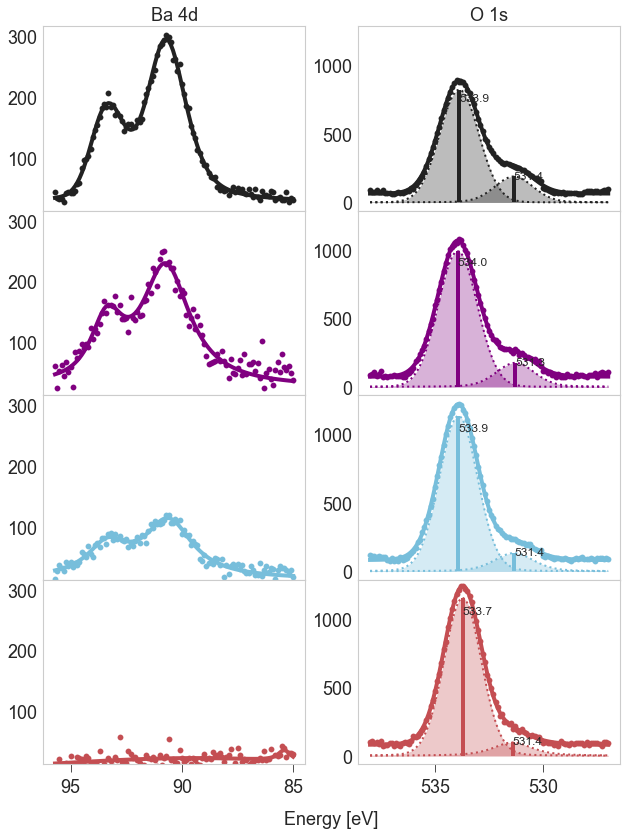

In [102]:
region = 'Ba_4d'
fig, ax = plt.subplots(4, 2, sharex=False, figsize=(9, 12), )
fig.add_subplot(111, frameon=False, xticks=[], yticks=[])  # Used for common xlabel and ylabel

for i,xp in enumerate(progba[::-1]):

    plot_fit_result(xp, 'Ba_4d', fitRes=xp.fit['Ba_4d'], ax=ax[i][0], flag_fill=False, plot_comps=False)
    plot_fit_result(xp, 'O_1s', fitRes=xp.fit['O_1s'], ax=ax[i][1], flag_fill=True)

    if i == 0: yl1 = ax[i][0].get_ylim()
    ax[i][0].set(ylim=yl1)
    
    ax[i][0].invert_xaxis()
    ax[i][1].invert_xaxis()
    ax[i][0].set(xlabel='', ylabel='')
    ax[i][1].set(xlabel='', ylabel='')

#     ax[i][0].get_legend().remove()
#     ax[i][1].get_legend().remove()

yl2 = ax[2][1].get_ylim()
for i in range(4):
    ax[i][1].set(ylim=yl2)
    
ax[0][0].set_title('Ba 4d')
ax[0][1].set_title('O 1s')

plt.xlabel('\n\nEnergy [eV]', ha='center')
plt.tight_layout(w_pad=0.5, h_pad=0.9, pad=0.3)

plt.subplots_adjust(hspace=.0)
plt.subplots_adjust(wspace=.2)

plt.gcf().savefig('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v3/fits_ba4d_o1s.png', dpi=200)

In [300]:
xp_norm2.color = 'k'

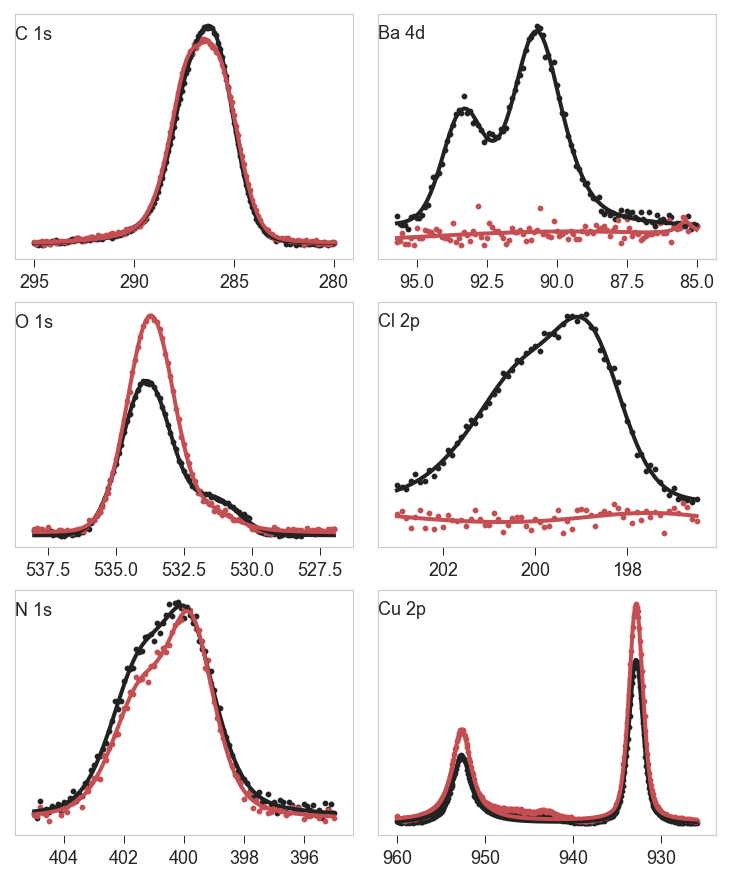

In [81]:
fig, ax = plt.subplots(3,2, sharex=False, figsize=(10, 12), )

reg2 = ['C_1s', 'O_1s', 'N_1s']
seps = [286.5, 532, 401]
for j,r in enumerate(reg2):
    for i, xp in enumerate([progba[-1], progba[0]]):
#         Fn = XPFit(xp, region = r)
#         Fn.double_voigt(sepPt=seps[j])
        plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[j][0], flag_fill=True, plot_comps=False)
    ax[j][0].set(xlabel='', ylabel='', yticks=[])
    ax[j][0].invert_xaxis()
    ax[j][0].text(s=r.replace('_', ' '), x=(ax[j][0].get_xlim()[0]), y=(ax[j][0].get_ylim()[1]*0.9))
    ax[j][0].minorticks_on()
    ax[j][0].tick_params('both', length=8, width=1, which='major')



reg1 = ['Ba_4d', 'Cl_2p', 'Cu_2p']
for j,r in enumerate(reg1):
    for i,xp in enumerate([progba[-1], progba[0]]):
        plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[j][1], flag_fill=True, plot_comps=False)
    ax[j][1].set(xlabel='', ylabel='', yticks=[])
    ax[j][1].invert_xaxis()
    ax[j][1].text(s=r.replace('_', ' '), x=(ax[j][1].get_xlim()[0]), y=(ax[j][1].get_ylim()[1]*0.9))
    
    ax[j][1].tick_params('both', length=8, width=1, which='major')
    
plt.tight_layout(w_pad=0.5, h_pad=0.2, pad=0.1)

In [105]:
banorm = [normalise_dfx(xp) for xp in progba]

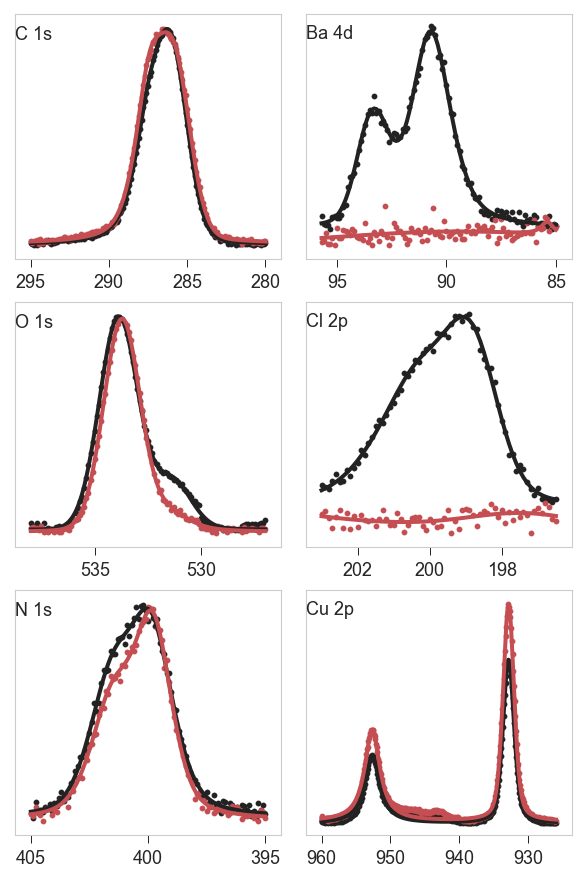

In [118]:
fig, ax = plt.subplots(3,2, sharex=False, figsize=(8, 12), )

reg2 = ['C_1s', 'O_1s', 'N_1s']
seps = [286.5, 532, 401]
for j,r in enumerate(reg2):
    for i, xp in enumerate([banorm[-1], banorm[0]]):
#         Fn = XPFit(xp, region = r)
#         Fn.double_voigt(sepPt=seps[j])
        plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[j][0], flag_fill=True, plot_comps=False)
    ax[j][0].set(xlabel='', ylabel='', yticks=[])
    ax[j][0].invert_xaxis()
    ax[j][0].text(s=r.replace('_', ' '), x=(ax[j][0].get_xlim()[0]), y=(ax[j][0].get_ylim()[1]*0.9))
    ax[j][0].minorticks_on()
    ax[j][0].tick_params('both', length=8, width=1, which='major')



reg1 = ['Ba_4d', 'Cl_2p', 'Cu_2p']
for j,r in enumerate(reg1):
    for i,xp in enumerate([progba[-1], progba[0]]):
        plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[j][1], flag_fill=True, plot_comps=False)
    ax[j][1].set(xlabel='', ylabel='', yticks=[])
    ax[j][1].invert_xaxis()
    ax[j][1].text(s=r.replace('_', ' '), x=(ax[j][1].get_xlim()[0]), y=(ax[j][1].get_ylim()[1]*0.9))
    
    ax[j][1].tick_params('both', length=8, width=1, which='major')
    
plt.tight_layout(w_pad=0.5, h_pad=0.2, pad=0.1)
plt.gcf().savefig('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v3/fbi_ba_3to1.png', dpi=200)

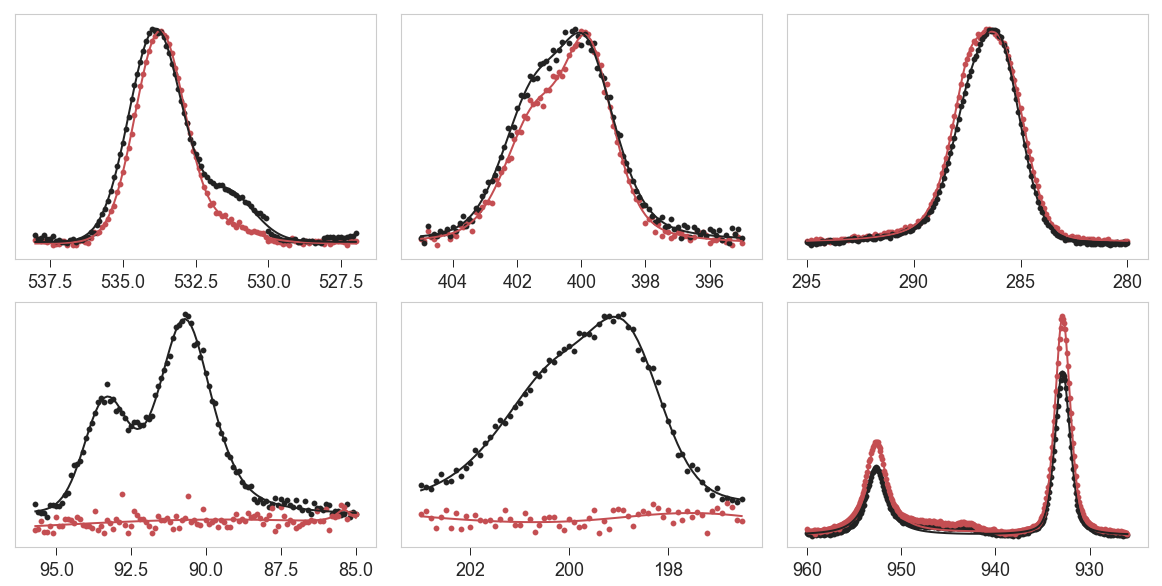

In [316]:
fig, ax = plt.subplots(2, 3, sharex=False, figsize=(16, 8), )

reg2 = ['O_1s', 'N_1s', 'C_1s',]
seps = [ 532, 401, 286.5,]
for j,r in enumerate(reg2):
    for i, xp in enumerate([banorm[-1], banorm[0]]):
        Fn = XPFit(xp, region = r)
        Fn.double_voigt(sepPt=seps[j])
        plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[0][j], flag_fill=True, plot_comps=False)
    ax[0][j].set(xlabel='', ylabel='', yticks=[])
#     ax[0][j].text(s=r.replace('_', ' '), x=(ax[0][j].get_xlim()[1]), y=(ax[0][j].get_ylim()[1]*0.9))
    
    ax[0][j].invert_xaxis()
    ax[0][j].minorticks_on()
    ax[0][j].tick_params('both', length=8, width=1, which='major')

reg1 = ['Ba_4d', 'Cl_2p', 'Cu_2p']
for j,r in enumerate(reg1):
    for i,xp in enumerate([progba[-1], progba[0]]):
        li = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[1][j], flag_fill=True, plot_comps=False)
    ax[1][j].set( xlabel='', ylabel='', yticks=[])
#     ax[1][j].text(s=r.replace('_', ' '), x=(ax[1][j].get_xlim()[1]), y=(ax[1][j].get_ylim()[1]*0.9))
    
    ax[1][j].invert_xaxis()
    ax[1][j].tick_params('both', length=8, width=1, which='major')
    
plt.tight_layout(w_pad=0.5, h_pad=0.2, pad=0.1)
# ax[0][0].legend(list(li.get_lines()), labels = [progba[-1].name, progba[0].name], ncol=2,
#             loc="upper right", bbox_to_anchor=(1.0, 1.2), fontsize=16)           


## FBI coverage

In [3]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_0*/**/*.uxy'
files = glob.glob(path, recursive=True)
files.sort()

In [4]:
fbi_exps = []
ba_exps = []
for f in files:
    if ('FBI_subl_' in f) and ('BaCl2' not in f):
        fbi_exps.append(read_processed_xp(f))
    elif 'BaCl2' in f:
        ba_exps.append(read_processed_xp(f))

clean_exps = []
for f in files:
    if 'clean' in f:
        clean_exps.append(read_processed_xp(f))

[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_05min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_10min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_15min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_20min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_21_Cu/proc/20210121_8-Cu_FBI_subl_05min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_21_Cu/proc/20210122_8-Cu_FBI_s

In [26]:
clean_exps[0].path

'/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_clean.uxy'

In [25]:
selection[1].path

'/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_05min.uxy'

In [5]:
sele2 = [xp for xp in fbi_exps if ('_7-' in xp.path) ]
selection = [clean_exps[0], fbi_exps[7]] + sele2
selection.append(fbi_exps[6])
# selection = scale_and_plot_spectra(selection, indRef=0, region='Cu_2p')

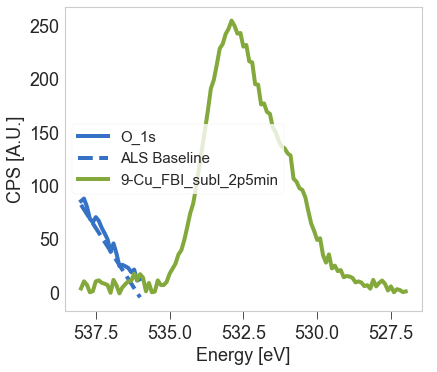

In [110]:
fix_tail_bg(selection[0], 'O_1s', edw=536, inplace=True);

In [111]:
for xp in selection:
    write_processed_xp(xp.path, xp)

In [14]:
for xp in selection:
    xp.name = xp.name[14:].replace('min', ' min')
selection[0].name = selection[0].name.replace('p', '.')
plt.rcParams['lines.linewidth'] = 4

In [52]:
selection[6].color='k'
selection[5].color='c'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2ac7aac8>,
      dtype=object)

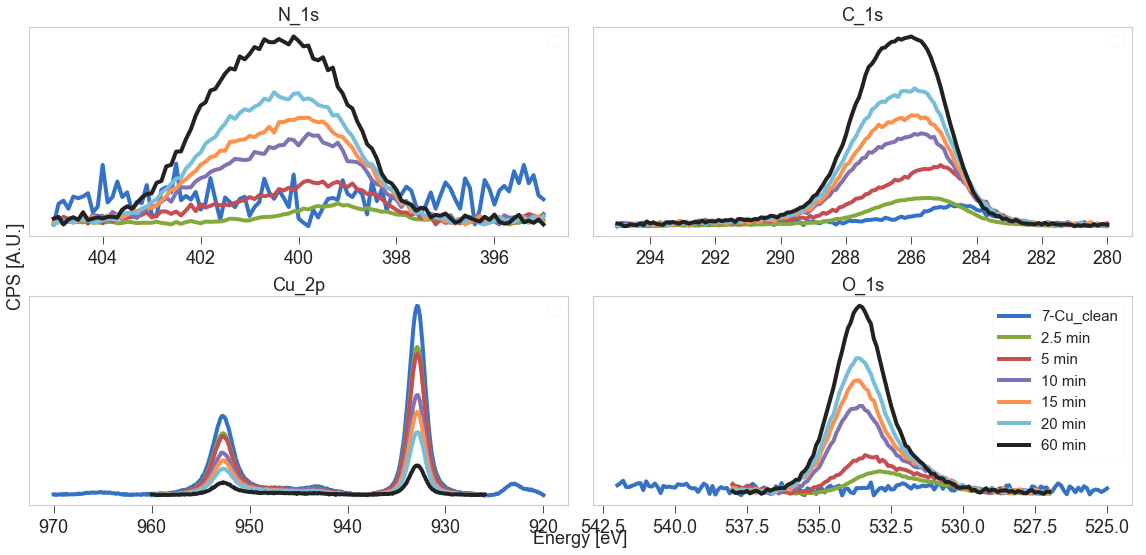

In [53]:
regions= ['N_1s', 'C_1s',  'Cu_2p', 'O_1s',]

plot_xp_regions(selection, regions, ncols=2)
# plt.gcf().savefig('/Users/pabloherrero/Dropbox/phd/papers/fbi_cu_sublim_v2/FBI_growth_many.png', dpi=200)

In [6]:
names = ['Clean cu', '0.47 ML', '0.65 ML', '1.09 ML', '1.41 ML', '1.82 ML', '3.02 ML']
colors = ['k', 'b', 'g', 'r', 'm', 'y', 'c']
for i,xp in enumerate(selection):
    xp.color = colors[i]
    xp.name = names[i]

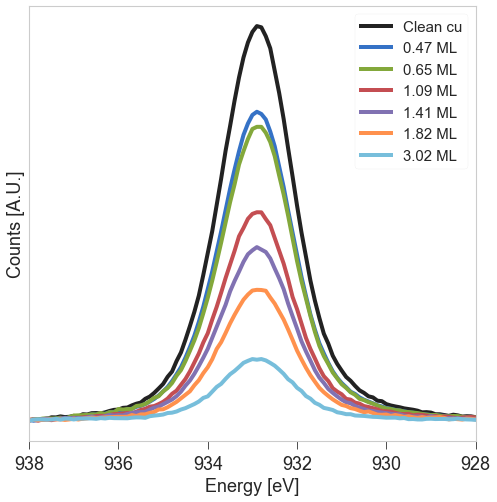

In [11]:
fig = plt.figure(figsize=(8, 8))
for xp in selection:
    li = plot_region(xp, 'Cu_2p')
    plt.gca().set(yticks=[], ylabel='Counts [A.U.]', xlim=(938, 928))

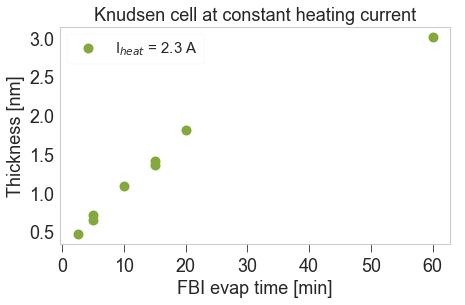

In [86]:
fig = plt.figure(figsize=(7,4))
texp = [2.5, 5, 5, 10, 15, 15, 20, 60]
thick = [0.47, 0.65, 0.72, 1.09, 1.36, 1.41, 1.82, 3.02]
plt.plot(texp, thick, 'og', markersize=10, label = 'I$_{heat}$ = 2.3 A')
plt.gca().set(xlabel='FBI evap time [min]', ylabel='Thickness [nm]', title='Knudsen cell at constant heating current')
plt.legend()

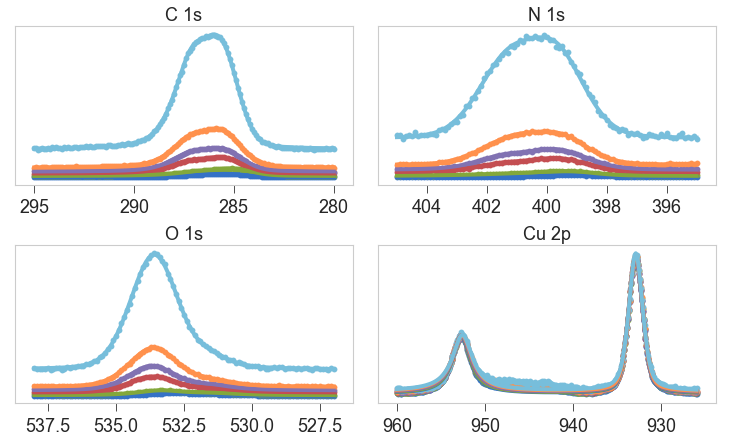

In [61]:
regions= ['C_1s', 'O_1s', 'N_1s', 'Cu_2p']
fig, ax = plt.subplots(2,2, sharex=False, figsize=(10, 6), )

seps = [286.5, 532, 401, 950]
for j,r in enumerate(regions):
    for i, xp in enumerate(selection):
        k, l = j%2, j//2
        Fn = XPFit(xp, region = r)
        Fn.double_voigt(sepPt=seps[j])
        plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[k][l], flag_fill=True, offset=1+i/100, plot_comps=False)
    ax[k][l].set(title=r.replace('_', ' '), xlabel='', ylabel='', yticks=[])
    ax[k][l].invert_xaxis()
plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
# plt.gcf().savefig('/Users/pabloherrero/Dropbox/phd/papers/fbi_cu_sublimation/v3/fbi_coverage_all.png', dpi=200)

### Normalized

In [9]:
norm_sel = [normalise_dfx(xp) for xp in selection]

In [ ]:
coverages = [0.47, 0.65, 1.09, 1.41, 1.82, 3.02]
for i,xp in enumerate(norm_sel):
    xp.name = coverages[i]
    

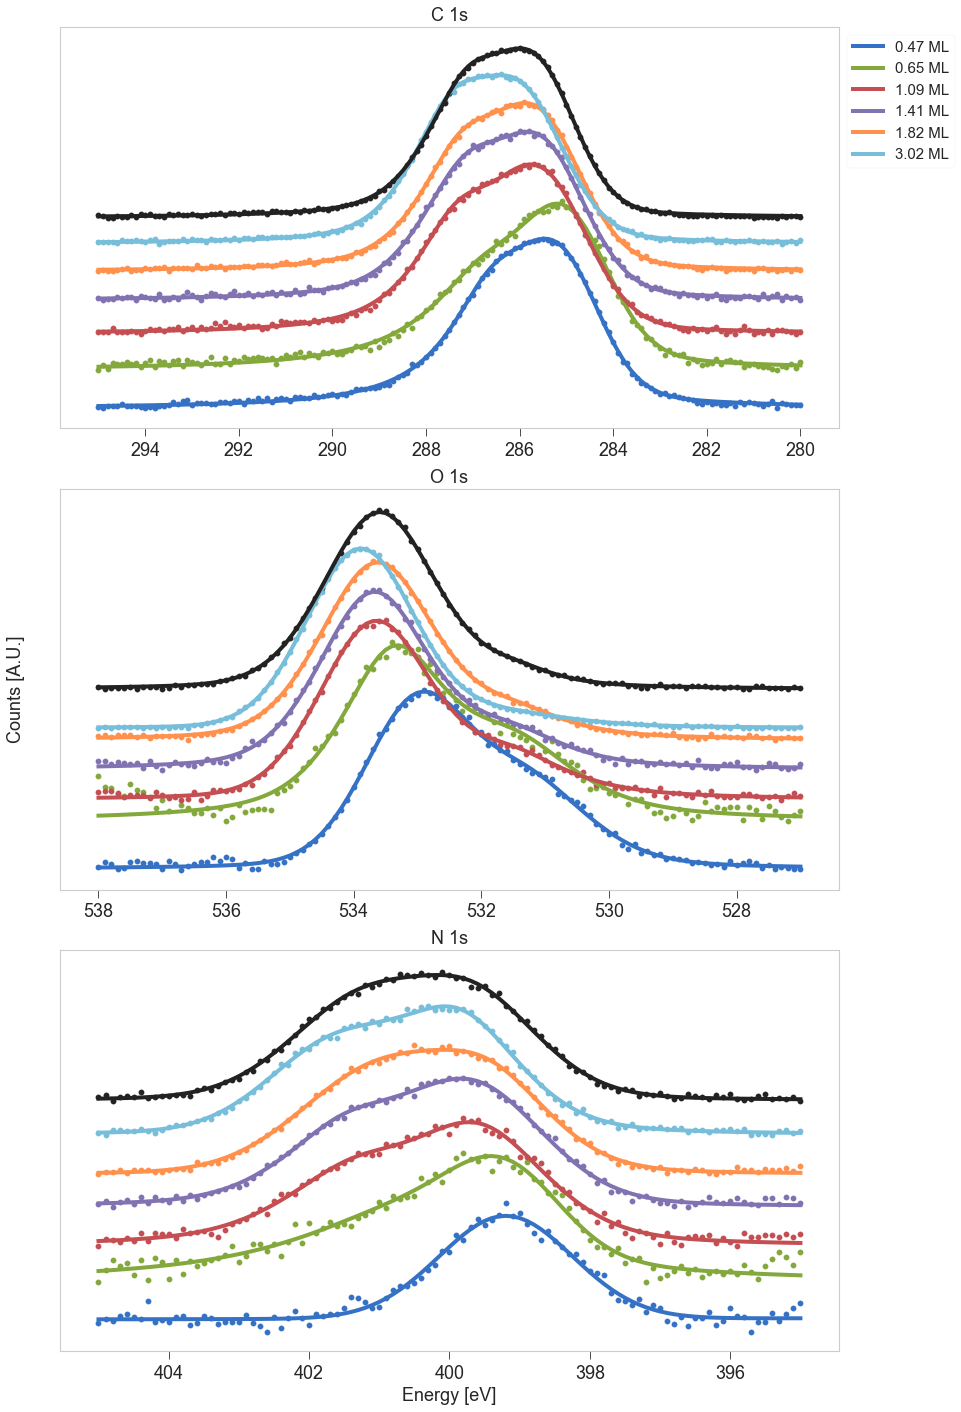

In [12]:
# selection = [xp for xp in fbi_exps if ('7-' in xp.path)]
regions= ['C_1s', 'O_1s', 'N_1s']
coverages = [0.47, 0.65, 1.09, 1.41, 1.82, 3.02]
fig, ax = plt.subplots(3, sharex=False, figsize=(12, 20), )
axx = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
axx.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Energy [eV]")
plt.ylabel("Counts [A.U.]")

seps = [286.5, 532, 401]
for j,r in enumerate(regions):
    for i, xp in enumerate(norm_sel):
        k, l = j%2, j//2
        Fn = XPFit(xp, region = r)
        Fn.double_voigt(sepPt=seps[j])
        li, _ = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[j], flag_fill=True, offset=1+8*i/10, plot_comps=False)
    ax[j].set(title=r.replace('_', ' '), xlabel='', ylabel='', yticks=[])
    ax[j].invert_xaxis()

plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)     #  First manage the space and THEN add the legend
ax[0].legend(list(li.get_lines()), labels = [str(cov) + ' ML' for cov in coverages], ncol=1,
            loc="upper left", bbox_to_anchor=(1., 1.))           

# fig.savefig('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v3/fbi_coverage_all_norm.png', dpi=200, bbox_inches = 'tight')

In [135]:
enmx, comx

([399.2, 399.8, 399.8, 399.8, 400.5, 400.1],
 [3.6030859014338024,
  4.400486932869589,
  4.366650039082655,
  4.438425884718759,
  4.381751107306329,
  4.41259188411626])

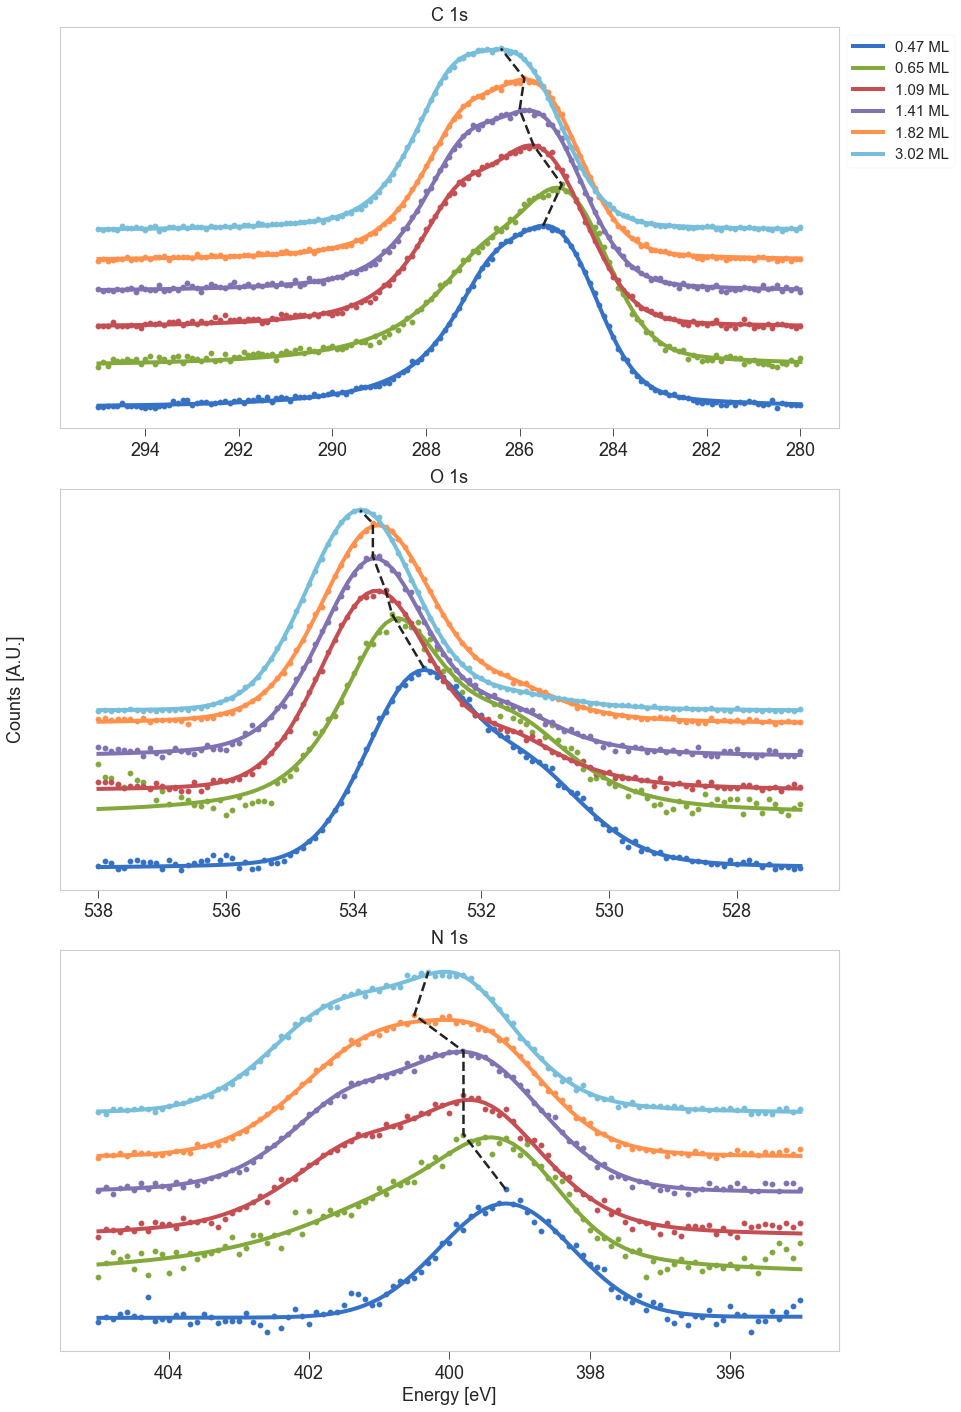

In [16]:
# selection = [xp for xp in fbi_exps if ('7-' in xp.path)]
regions= ['C_1s', 'O_1s', 'N_1s']
coverages = [0.47, 0.65, 1.09, 1.41, 1.82, 3.02]
fig, ax = plt.subplots(3, sharex=False, figsize=(12, 20), )
axx = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
axx.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Energy [eV]")
plt.ylabel("Counts [A.U.]")

seps = [286.5, 532, 401]
for j,r in enumerate(regions):
    enmx, comx = [], []
    for i, xp in enumerate(norm_sel[:-1]):
#         k, l = j%2, j//2
#         Fn = XPFit(xp, region = r)
#         Fn.double_voigt(sepPt=seps[j])
        li, off = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[j], flag_fill=True , plot_comps=False,
                                  offset=1+8*i/10)
        argmx = np.argmax(xp.dfx[r].counts)

        enmx.append(xp.dfx[r].energy.loc[argmx])
        comx.append(xp.dfx[r].counts.loc[argmx] + off)
    ax[j].plot(enmx, comx, '--k', lw=2.5)
    ax[j].set(title=r.replace('_', ' '), xlabel='', ylabel='', yticks=[])
    ax[j].invert_xaxis()

plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)     #  First manage the space and THEN add the legend
ax[0].legend(list(li.get_lines()), labels = [str(cov) + ' ML' for cov in coverages], ncol=1,
            loc="upper left", bbox_to_anchor=(1., 1.))           

# fig.savefig('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v3/fbi_coverage_all_norm.png', dpi=200, bbox_inches = 'tight')

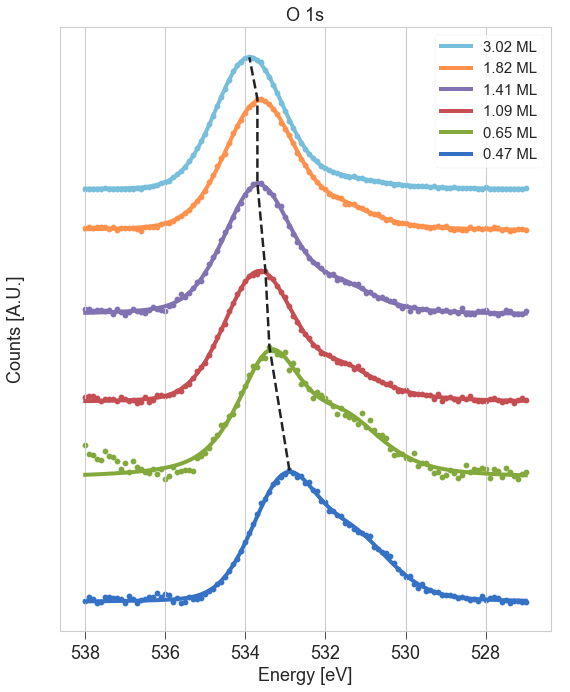

In [74]:
# selection = [xp for xp in fbi_exps if ('7-' in xp.path)]
regions= ['C_1s', 'O_1s', 'N_1s']
coverages = [0.47, 0.65, 1.09, 1.41, 1.82, 3.02]
fig, ax = plt.subplots(1, sharex=False, figsize=(8, 10))
ax.grid(True, axis='both')

axx = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
axx.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Energy [eV]")
plt.ylabel("Counts [A.U.]")

seps = [286.5, 532, 401]
enmx, comx = [], []
r = 'O_1s'
for i, xp in enumerate(norm_sel[:-1]):
#         k, l = j%2, j//2
#         Fn = XPFit(xp, region = r)
#         Fn.double_voigt(sepPt=seps[j])
    li, off = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax, flag_fill=True , plot_comps=False,
                              offset=1+3*i)
    argmx = np.argmax(xp.dfx[r].counts)

    enmx.append(xp.dfx[r].energy.loc[argmx])
    comx.append(xp.dfx[r].counts.loc[argmx] + off)
ax.plot(enmx, comx, '--k', lw=2.5)
ax.set(title=r.replace('_', ' '), xlabel='', ylabel='', yticks=[])
ax.invert_xaxis()

plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)     #  First manage the space and THEN add the legend
handles = list(li.get_lines())
labels = [str(cov) + ' ML' for cov in coverages]#[::-1]
handles = handles[-2::-1]

labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
labels = labels[::-1]
ax.legend(handles, labels, ncol=1,)
#            loc="upper left", bbox_to_anchor=(1., 1.))           

# fig.savefig('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v3/fbi_coverage_all_norm.png', dpi=200, bbox_inches = 'tight')

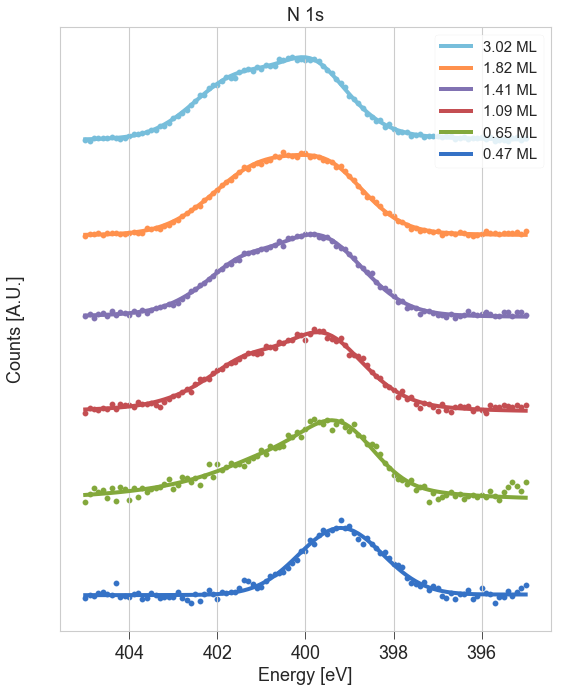

In [76]:
# selection = [xp for xp in fbi_exps if ('7-' in xp.path)]
regions= ['C_1s', 'O_1s', 'N_1s']
coverages = [0.47, 0.65, 1.09, 1.41, 1.82, 3.02]
fig, ax = plt.subplots(1, sharex=False, figsize=(8, 10))
ax.grid(True, axis='both')

axx = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
axx.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Energy [eV]")
plt.ylabel("Counts [A.U.]")

seps = [286.5, 532, 401]
enmx, comx = [], []
r = 'N_1s'
for i, xp in enumerate(norm_sel[:-1]):
#         k, l = j%2, j//2
#         Fn = XPFit(xp, region = r)
#         Fn.double_voigt(sepPt=seps[j])
    li, off = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax, flag_fill=True , plot_comps=False,
                              offset=1+3*i)
#     argmx = np.argmax(xp.dfx[r].counts)

#     enmx.append(xp.dfx[r].energy.loc[argmx])
#     comx.append(xp.dfx[r].counts.loc[argmx] + off)
ax.plot(enmx, comx, '--k', lw=2.5)
ax.set(title=r.replace('_', ' '), xlabel='', ylabel='', yticks=[])
ax.invert_xaxis()

plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)     #  First manage the space and THEN add the legend
handles = list(li.get_lines())
labels = [str(cov) + ' ML' for cov in coverages]#[::-1]
handles = handles[-2::-1]

labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
labels = labels[::-1]
ax.legend(handles, labels, ncol=1,)
#            loc="upper left", bbox_to_anchor=(1., 1.))           

# fig.savefig('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v3/fbi_coverage_all_norm.png', dpi=200, bbox_inches = 'tight')

In [50]:
list(li.get_lines())[::-1]

In [ ]:
tsubl4 = [5, 10, 15, 20, 5, 15, 60, 2.5]
matrix([[6.51323846e-01, 1.16140270e-03],
        [1.08637052e+00, 3.27288126e-03],
        [1.41274162e+00, 3.49811320e-03],
        [1.82644117e+00, 3.82795998e-03],
        [7.24651170e-01, 1.30998972e-03],
        [1.54539729e+00, 3.59823743e-03],
        [3.02141495e+00, 5.11686513e-03],
        [4.75515898e-01, 8.51986016e-04]])
coverages = [0.47, 0.65, 1.09, 1.41, 1.82, 3.02]

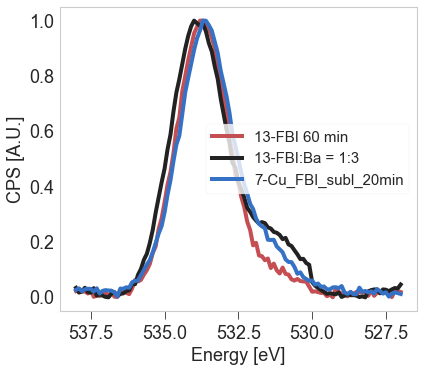

In [128]:
color = ['r', 'k', 'b']
for i,xp in enumerate([progba[0], progba[-1], selection[3]]):
    xpn = normalise_dfx(xp)
    plot_region(xpn, 'O_1s', col=color[i])

## Progressive barium

In [123]:
for xp in progba:
    xp.name = xp.name[3:]

progba[0].name = 'FBI:Ba = 1:0'

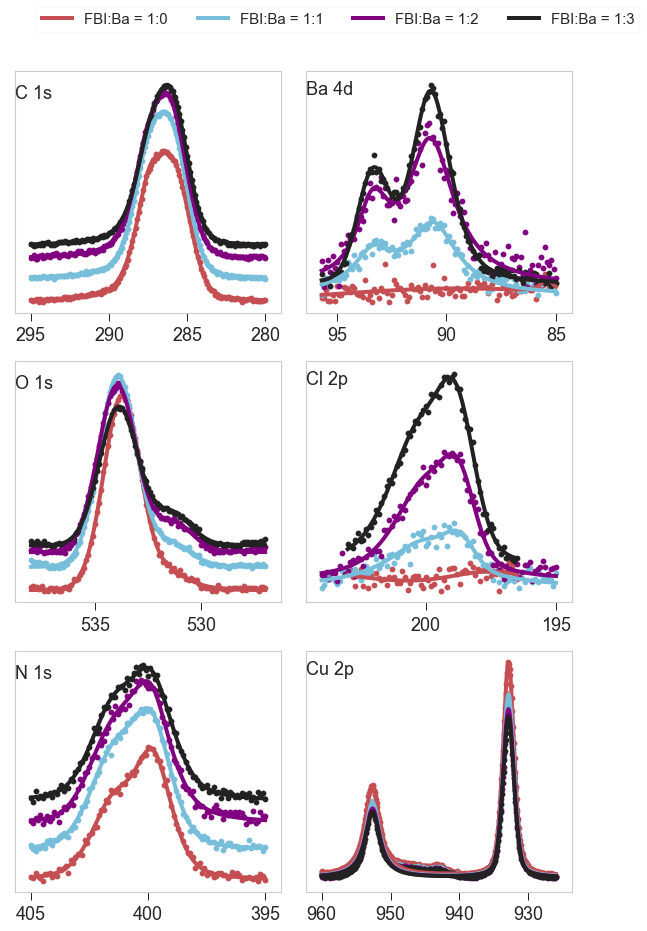

In [127]:
fig, ax = plt.subplots(3, 2, sharex=False, figsize=(8, 12), )

reg2 = ['C_1s', 'O_1s', 'N_1s']
seps = [286.5, 532, 401]
for j,r in enumerate(reg2):
    for i, xp in enumerate(progba):
#         xp = normalise_dfx(xpo)
        Fn = XPFit(xp, region = r)
        Fn.double_voigt(sepPt=seps[j])
        plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[j][0], offset=1+5*i/10,
                        flag_fill=True, plot_comps=False)
    ax[j][0].set(xlabel='', ylabel='', yticks=[])
    ax[j][0].invert_xaxis()
    ax[j][0].text(s=r.replace('_', ' '), x=(ax[j][0].get_xlim()[0]), y=(ax[j][0].get_ylim()[1]*0.9))
    ax[j][0].minorticks_on()
    ax[j][0].tick_params('both', length=8, width=1, which='major')



reg1 = ['Ba_4d', 'Cl_2p', 'Cu_2p']
for j,r in enumerate(reg1):
    for i,xp in enumerate(progba):
        li = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[j][1], flag_fill=True, plot_comps=False)
    ax[j][1].set( xlabel='', ylabel='', yticks=[])
    ax[j][1].invert_xaxis()
    ax[j][1].tick_params('both', length=8, width=1, which='major')
    ax[j][1].text(s=r.replace('_', ' '), x=(ax[j][1].get_xlim()[0]), y=(ax[j][1].get_ylim()[1]*0.9))
    
# ax[0][0].set(ylabel='Counts [A.U.]')
# ax[1][0].set(ylabel='Counts [A.U.]')
# ax[1][1].set(xlabel='Energy [eV]')

plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
ax[0][0].legend(list(li.get_lines()), labels = [xp.name for xp in progba], ncol=len(selection),
            loc="upper left", bbox_to_anchor=(0.05, 1.3))           

fig.savefig('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v3/fbi_prog_ba.png', dpi=200, bbox_inches = 'tight')

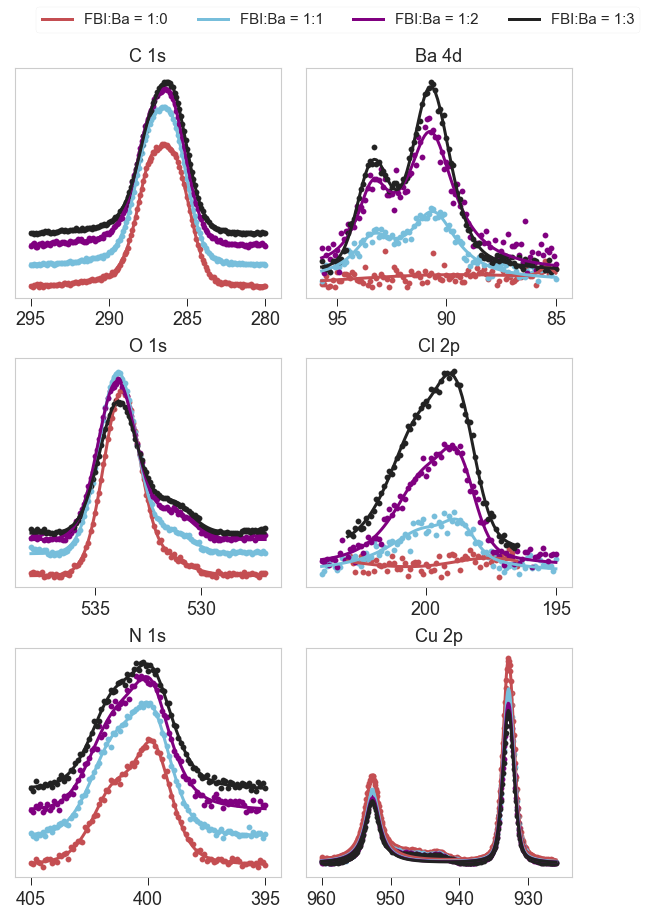

In [67]:
fig, ax = plt.subplots(3, 2, sharex=False, figsize=(8, 12), )

reg2 = ['C_1s', 'O_1s', 'N_1s']
seps = [286.5, 532, 401]
for j,r in enumerate(reg2):
    for i, xp in enumerate(progba):
#         xp = normalise_dfx(xpo)
        Fn = XPFit(xp, region = r)
        Fn.double_voigt(sepPt=seps[j])
        plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[j][0], offset=1+5*i/10,
                        flag_fill=True, plot_comps=False)
    ax[j][0].set(title=r.replace('_', ' '), xlabel='', ylabel='', yticks=[])
    ax[j][0].invert_xaxis()
    ax[j][0].minorticks_on()
    ax[j][0].tick_params('both', length=8, width=1, which='major')


reg1 = ['Ba_4d', 'Cl_2p', 'Cu_2p']
for j,r in enumerate(reg1):
    for i,xp in enumerate(progba):
        li = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[j][1], flag_fill=True, plot_comps=False)
    ax[j][1].set(title=r.replace('_', ' '), xlabel='', ylabel='', yticks=[])
    ax[j][1].invert_xaxis()
    ax[j][1].tick_params('both', length=8, width=1, which='major')
    
# ax[0][0].set(ylabel='Counts [A.U.]')
# ax[1][0].set(ylabel='Counts [A.U.]')
# ax[1][1].set(xlabel='Energy [eV]')

plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
ax[0][0].legend(list(li.get_lines()), labels = [xp.name for xp in progba], ncol=len(selection),
            loc="upper left", bbox_to_anchor=(0.05, 1.3))           

# fig.savefig('/Users/pabloherrero/Dropbox/phd/papers/fbi_cu_sublimation/v3/fbi_prog_ba.png', dpi=200, bbox_inches = 'tight')

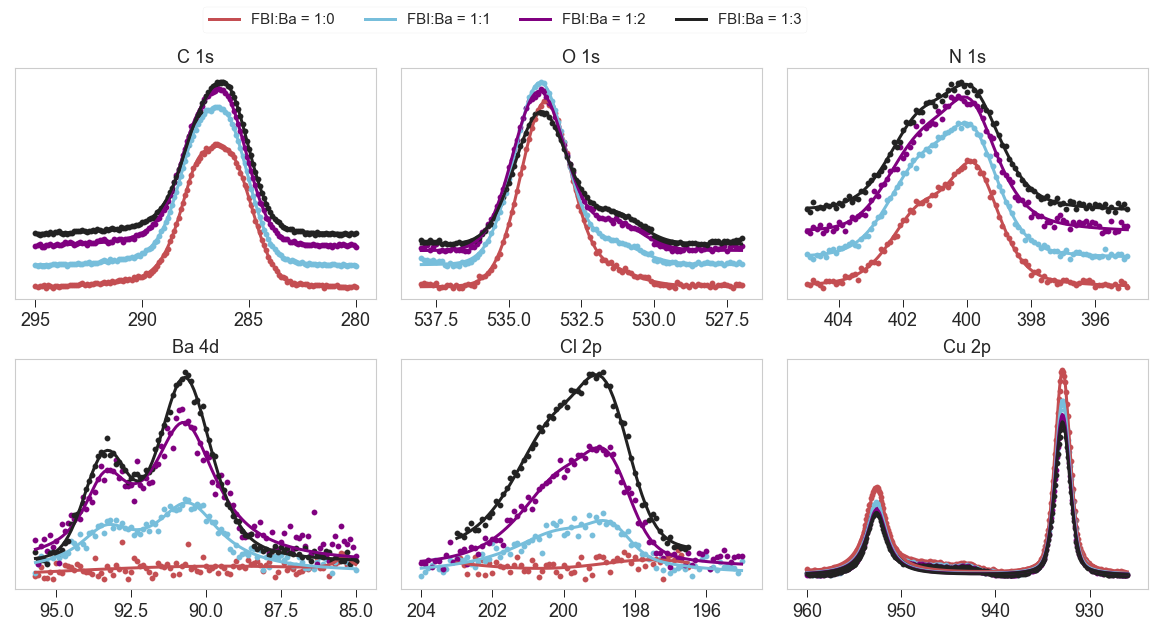

In [163]:
fig, ax = plt.subplots(2, 3, sharex=False, figsize=(16, 8), )

reg2 = ['C_1s', 'O_1s', 'N_1s']
seps = [286.5, 532, 401]
for j,r in enumerate(reg2):
    for i, xp in enumerate(progba):
#         xp = normalise_dfx(xpo)
        Fn = XPFit(xp, region = r)
        Fn.double_voigt(sepPt=seps[j])
        plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[0][j], offset=1+5*i/10,
                        flag_fill=True, plot_comps=False)
    ax[0][j].set(title=r.replace('_', ' '), xlabel='', ylabel='', yticks=[])
    ax[0][j].invert_xaxis()
    ax[0][j].minorticks_on()
    ax[0][j].tick_params('both', length=8, width=1, which='major')

reg1 = ['Ba_4d', 'Cl_2p', 'Cu_2p']
for j,r in enumerate(reg1):
    for i,xp in enumerate(progba):
        li = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[1][j], flag_fill=True, plot_comps=False)
    ax[1][j].set(title=r.replace('_', ' '), xlabel='', ylabel='', yticks=[])
    ax[1][j].invert_xaxis()
    ax[1][j].tick_params('both', length=8, width=1, which='major')

plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
ax[0][0].legend(list(li.get_lines()), labels = [xp.name for xp in progba], ncol=len(selection),
            loc="upper left", bbox_to_anchor=(0.5, 1.3))  

## Coverages plots

In [306]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021*/**/*.uxy'

files = glob.glob(path, recursive=True)
files.sort()
ffi = []
for f in files:
    if 'calibration' not in f:
        ffi.append(f)

files = ffi
files

cu_exps = [read_processed_xp(f) for f in files]


[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_05min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_10min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_15min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_20min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_clean.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_21_Cu/proc/20210121_8-Cu_FBI_subl_05min

In [255]:
def guess_clean_xp(exp_set):
    lref = []
    li = []
    for i, xp in enumerate(exp_set):
        if 'clean' in xp.name: lref.append(i)
        else: li.append(i)
    if len(lref) == 1:
        inds = li + lref
        return inds
    elif len(lref) < 1:
        print('Did not find clean experiments in this set!')
    else:
        print('Too many clean experiments!')
        
def arrange_coverages(experiments: list, inds: list,
                      r_ml: float, region: str, mfp: float, takeoff: float)->np.matrix:
    """Estimate n_layers for a list of experiments following the indices inds
    Parameters:
     - experiments: list of XPS_experiment to look into
     - inds: list of indices. It must be arranged such that each set of measurements
             has its reference (clean substrate) index at the end of each list.
             Example:  inds = [[0,1,2,3,5,7,8, 4], [9, 10]]
             will take experiments[4] as clean_substrate, and compute the thickness of experiments[0],
             experiments[1], experiments[2]... Then it will take experiments[10] as clean_substrate and
             compute the thickness for experiments[9]
     - all other params must be passed as for n_layers
    Returns:
        layers_res: matrix (M x 2), with column 0 is the mean value of n_layers and column 1 its error, and
        where M is the number of experiments passed for computation.
    """
    layers_res = []
    for lref in inds:
        try:
            for li in lref[:-1]:
                layi = n_layers(xpf=experiments[li], xp0=experiments[lref[-1]],
                                           r_ml = r_ml, region=region, mfp=mfp, takeoff=takeoff) 
                experiments[li].area['layers'] = layi[0]
                experiments[li].area['dlayers'] = layi[1]
                
                layers_res.append(layi)
        except TypeError:
            pass
    layers_res = np.matrix(layers_res)
    return layers_res

def plot_coverages(experiments):
    layers, dlayers = [], []
    names = []
    for xp in experiments:
        try:
            layers.append(xp.area['layers'])
            dlayers.append(xp.area['dlayers'])
            names.append(xp.name)
        except KeyError:
            pass

    ax = plt.gca()
    ax.errorbar(x=names, y=layers, yerr=dlayers, fmt='o', label='Rate $R_0$')
    ax.set_ylabel('Layers')
    plt.draw()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend()

In [375]:
nrexp = [int(re.findall('[0-9]+-', cu_exps[0].name)[0][:-1])]
exp_set = []
inds = []
for i, xp in enumerate(cu_exps):
    try:  # Locate the number of sample: xp.name should start f.ex. by '8-Cu_FBI...' 
        nr = int(re.findall('[0-9]+[-,_]', xp.name)[0][:-1])
    except IndexError: # If incorrect format, skip this xp
        print('Warning: incorrect xp.name format for', xp.name)
        nr = 10
    
    if nr == nrexp[-1]:
        exp_set.append(xp)
    else:
        print('Exp_set:', [xp.name for xp in exp_set])
        inds = guess_clean_xp(exp_set)
        print(inds)
        arrange_coverages(exp_set, [inds], 
                         r_ml = 1.1*nm, region='Cu_2p', mfp = 1.85*nm, takeoff = 10)
        nrexp.append(nr)
        exp_set = [xp]
print('Exp_set:', [xp.name for xp in exp_set])

inds = guess_clean_xp(exp_set) # Last exp_set is not accounted for with the else
arrange_coverages(exp_set, [inds],
                 r_ml = 1.1*nm, region='Cu_2p', mfp = 1.85*nm, takeoff = 10)

Exp_set: ['7-Cu_FBI_subl_5min', '7-Cu_FBI_subl_10min', '7_Cu-FBI_subl_15min', '7-Cu_FBI_subl_20min', '7-Cu_clean']
[0, 1, 2, 3, 4]
Exp_set: ['8-Cu_FBI_subl_05min', '8-Cu_clean', '8-Cu_FBI_subl_15min', '8-Cu_FBI_subl_60min']
[0, 2, 3, 1]
Exp_set: ['9-Cu_FBI_subl_2p5min', '9-Cu_clean']
[0, 1]
Exp_set: ['11-FBI 20min', '11-FBI 20min, BaCl$_2$ 2min', '11-Cu_clean']
[0, 1, 2]
Exp_set: ['12-FBI 20min', '12-FBI 20min, BaCl$_2$ 4min', '12-Cu_clean']
[0, 1, 2]
Exp_set: ['13-FBI 60 min', '"13-FBI:Ba', '"13-FBI:Ba', '"13-FBI:Ba', '13-Cu_clean']
[0, 1, 2, 3, 4]
Exp_set: ['14-FBI 8min', '14-FBI 8min, BaCl$_2$ 1min', '14-Cu_clean2']
[0, 1, 2]
Exp_set: ['16-Cu_clean', '16-Cu_FBI_subl_15min', '16-Cu_FBI_subl_22min', '16-Cu_FBI_subl_8min']


matrix([[0.46099815, 0.00147795],
        [0.57469614, 0.00187683],
        [0.20595483, 0.00063701]])

In [280]:
n_layers(xpf=cu_exps[5], xp0=cu_exps[6],
        r_ml = 1.1*nm, region='Cu_2p', mfp=1.85*nm, takeoff=10) 

(-1.4508434718750405, -0.0032895929623820465)

In [376]:
for xp in cu_exps:
    try:
        print(xp.name, xp.area['layers'])
    except KeyError: pass

7-Cu_FBI_subl_5min 0.6487437979940064
7-Cu_FBI_subl_10min 1.0805298212261916
7_Cu-FBI_subl_15min 1.4051462373885322
7-Cu_FBI_subl_20min 1.816621594559621
8-Cu_FBI_subl_05min 0.10251184906466321
8-Cu_FBI_subl_15min 1.0043494358994436
8-Cu_FBI_subl_60min 2.4436725806627115
9-Cu_FBI_subl_2p5min 0.473632266606096
11-FBI 20min 0.4991203191279348
11-FBI 20min, BaCl$_2$ 2min 0.5493118418479295
12-FBI 20min 0.44720971100225965
12-FBI 20min, BaCl$_2$ 4min 0.5016757846423242
13-FBI 60 min 0.8954621458661511
"13-FBI:Ba 1.1429712569462513
"13-FBI:Ba 1.2644100132637135
"13-FBI:Ba 1.3265161850773732
14-FBI 8min 0.1214782927703221
14-FBI 8min, BaCl$_2$ 1min 0.1723018213130005
16-Cu_FBI_subl_15min 0.4609981536902545
16-Cu_FBI_subl_22min 0.5746961428543874
16-Cu_FBI_subl_8min 0.20595483448625806


In [ ]:
coverages = [0.47, 0.65, 1.09, 1.41, 1.82, 3.02]


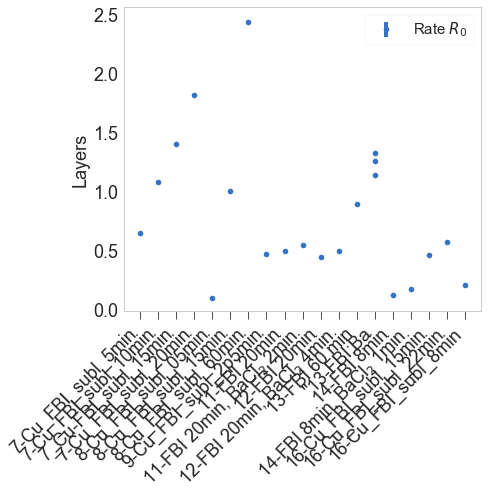

In [377]:
plot_coverages(cu_exps)